# Armado de Dataset Entrenable - Diario

## Armado de datos

In [33]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import itertools
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler

In [34]:
df_2023 = pd.read_csv('../data/processed/recorridos/trips_2023.csv')
df_2024 = pd.read_csv('../data/processed/recorridos/trips_2024.csv')
df = pd.concat([df_2023, df_2024], ignore_index=True)
print(f"Shape combinado: {df.shape}")
df = df[df['duracion_recorrido'] <= 7200]
df = df.dropna()

Shape combinado: (4777976, 17)


In [35]:
# Crear el rango temporal deseado (con ventanas de 30 minutos)
rango_tiempo = pd.date_range(start='2023-01-01', end='2024-08-31 23:59:59', freq='1D')

# Obtener la lista de estaciones
estaciones = df['id_estacion_destino'].unique()

# Producto cartesiano de estaciones x ventanas
multiindex = pd.MultiIndex.from_product([rango_tiempo, estaciones], names=['ventana', 'id_estacion'])

# Crear el DataFrame base
df_base = pd.DataFrame(index=multiindex).reset_index()

In [36]:
# Crear columna ventana diaria para arribos y partidas
df['ventana'] = pd.to_datetime(df['fecha_destino_recorrido']).dt.floor('1D')

# === ARRIBOS ===
arribos = df.groupby(['ventana', 'id_estacion_destino']).size().reset_index(name='bicis_arriban')

df_base = df_base.merge(arribos, left_on=['ventana', 'id_estacion'], right_on=['ventana', 'id_estacion_destino'], how='left')
print(df_base.columns)

df_base['bicis_arriban'] = df_base['bicis_arriban'].fillna(0).astype(int)
df_base.drop(columns=['id_estacion_destino'], inplace=True)

# === PARTIDAS ===
df['ventana'] = pd.to_datetime(df['fecha_origen_recorrido']).dt.floor('1D')
partidas = df.groupby(['ventana', 'id_estacion_origen']).size().reset_index(name='partidas')
partidas = partidas.rename(columns={'id_estacion_origen': 'id_estacion'})

# Crear features de LAG
for lag in [1, 2, 3]:
    partidas[f'partidas_lag_{lag}'] = partidas.groupby('id_estacion')['partidas'].shift(lag)

# Merge con df_base
df_base = df_base.merge(partidas, on=['ventana', 'id_estacion'], how='left')

# Rellenar con ceros
cols_lags = ['partidas', 'partidas_lag_1', 'partidas_lag_2', 'partidas_lag_3']
df_base[cols_lags] = df_base[cols_lags].fillna(0).astype(int)

Index(['ventana', 'id_estacion', 'id_estacion_destino', 'bicis_arriban'], dtype='object')


In [37]:
# === GÉNERO ===
df['ventana'] = pd.to_datetime(df['fecha_destino_recorrido']).dt.floor('1D')  # aseguramos la misma ventana

conteo_genero = df.groupby(['ventana', 'id_estacion_destino', 'genero']).size().reset_index(name='conteo')

# Pivot para convertir géneros en columnas
genero_pivot = conteo_genero.pivot(index=['ventana', 'id_estacion_destino'],
                                   columns='genero',
                                   values='conteo').fillna(0).astype(int)

genero_pivot = genero_pivot.rename(columns={
    'MALE': 'cant_male',
    'FEMALE': 'cant_female',
    'OTHER': 'cant_other'
}).reset_index()

# Merge con df_base
df_base = df_base.merge(genero_pivot,
                        left_on=['ventana', 'id_estacion'],
                        right_on=['ventana', 'id_estacion_destino'],
                        how='left')

df_base = df_base.drop(columns=['id_estacion_destino'])

# Rellenar NaNs de género
for col in ['cant_male', 'cant_female', 'cant_other']:
    if col not in df_base.columns:
        df_base[col] = 0
    else:
        df_base[col] = df_base[col].fillna(0).astype(int)

In [38]:
# Extraer latitud y longitud únicas por estación destino
estaciones = df[['id_estacion_destino', 'lat_estacion_destino', 'long_estacion_destino']].drop_duplicates()

# Renombrar columnas para el merge
estaciones = estaciones.rename(columns={
    'id_estacion_destino': 'id_estacion',
    'lat_estacion_destino': 'latitud',
    'long_estacion_destino': 'longitud'
})

# Unir con df_base por id_estacion
df_base = df_base.merge(estaciones, on='id_estacion', how='left')

In [39]:
# Crear ventana diaria
df['ventana'] = pd.to_datetime(df['fecha_destino_recorrido']).dt.floor('1D')

# Agrupar por ventana diaria, estación y modelo
conteo_modelo = df.groupby(['ventana', 'id_estacion_destino', 'modelo_bicicleta']).size().reset_index(name='conteo')

# Pivotear a columnas separadas por modelo de bicicleta
modelo_pivot = conteo_modelo.pivot(index=['ventana', 'id_estacion_destino'],
                                   columns='modelo_bicicleta',
                                   values='conteo').fillna(0).astype(int)

# Renombrar columnas
modelo_pivot = modelo_pivot.rename(columns={
    'FIT': 'cant_fit',
    'ICONIC': 'cant_iconic'
}).reset_index()

# Merge con df_base
df_base = df_base.merge(modelo_pivot,
                        left_on=['ventana', 'id_estacion'],
                        right_on=['ventana', 'id_estacion_destino'],
                        how='left')

# Limpiar columna auxiliar
df_base = df_base.drop(columns=['id_estacion_destino'])

# Rellenar NaNs con ceros
for col in ['cant_fit', 'cant_iconic']:
    if col not in df_base.columns:
        df_base[col] = 0
    else:
        df_base[col] = df_base[col].fillna(0).astype(int)


In [40]:
print(df.shape)
print(df_base.shape)

(4724761, 18)
(347739, 14)


In [41]:
for cluster_id in sorted(dias['cluster'].unique()):
    dias_en_cluster = dias[dias['cluster'] == cluster_id]['dia_semana'].tolist()
    print(f"Cluster {cluster_id}: {dias_en_cluster}")


Cluster 0: ['Saturday', 'Sunday']
Cluster 1: ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday']


In [42]:
print(df_base.shape)

(347739, 14)


In [43]:
df_base['es_finde'] = (df_base['ventana'].dt.dayofweek >= 5).astype(int)

In [45]:
print(df_base.shape)

(347739, 15)


In [46]:
# Agrupar por estación
estaciones = (
    df_base
    .groupby('id_estacion')
    .agg({
        'bicis_arriban': 'mean',
        'partidas': 'mean'
    })
    .reset_index()
)

In [47]:
X = estaciones[['bicis_arriban', 'partidas']]
X_scaled = StandardScaler().fit_transform(X)

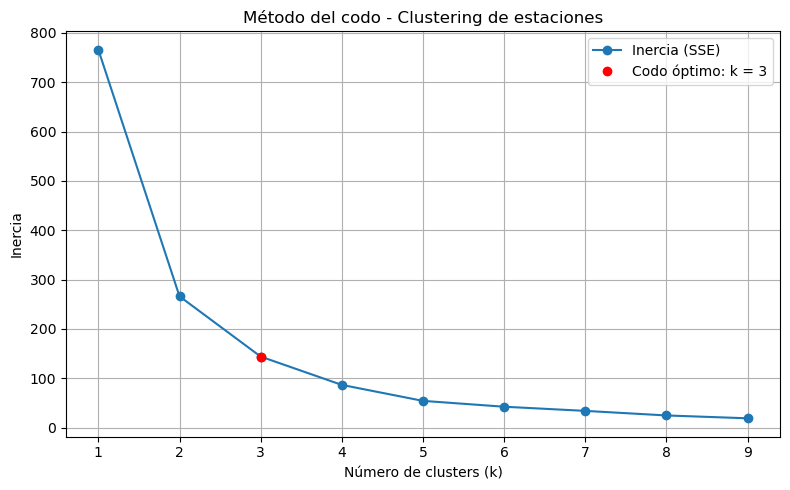

✅ Cantidad óptima de clusters según el codo: 3


In [48]:
inercia = []
ks = range(1, 10)

for k in ks:
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(X_scaled)
    inercia.append(kmeans.inertia_)

# Calcular "codo" geométricamente
x = np.array(list(ks))
y = np.array(inercia)
p1 = np.array([x[0], y[0]])
p2 = np.array([x[-1], y[-1]])

def distancia(p, a, b):
    return np.abs(np.cross(b - a, a - p)) / np.linalg.norm(b - a)

distancias = [distancia(np.array([x[i], y[i]]), p1, p2) for i in range(len(x))]
k_optimo = x[np.argmax(distancias)]

# Graficar codo
plt.figure(figsize=(8, 5))
plt.plot(x, y, marker='o', label='Inercia (SSE)')
plt.plot(k_optimo, y[np.argmax(distancias)], 'ro', label=f'Codo óptimo: k = {k_optimo}')
plt.xlabel("Número de clusters (k)")
plt.ylabel("Inercia")
plt.title("Método del codo - Clustering de estaciones")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

print(f"✅ Cantidad óptima de clusters según el codo: {k_optimo}")


In [49]:
# Entrenar el modelo final de clustering
kmeans = KMeans(n_clusters=k_optimo, random_state=42)
estaciones['cluster'] = kmeans.fit_predict(X_scaled)

In [50]:
# Obtener el centroide promedio de cada cluster
centros = kmeans.cluster_centers_

# Tomamos el valor medio de 'bicis_arriban' en el centroide
intensidades = centros[:, 0]  # Asumiendo que 'bicis_arriban' fue la primera columna

# Ordenar de menor a mayor uso
orden = intensidades.argsort()

# Asignar etiquetas interpretables según orden
etiquetas = {orden[0]: 'fantasma'}
if len(orden) >= 3:
    etiquetas[orden[1]] = 'moderada'
    etiquetas[orden[2]] = 'central'
elif len(orden) == 2:
    etiquetas[orden[1]] = 'central'

# Agregar columna con etiqueta de tipo de estación
estaciones['tipo_estacion'] = estaciones['cluster'].map(etiquetas)


In [51]:
print(estaciones[['id_estacion', 'bicis_arriban', 'partidas', 'cluster', 'tipo_estacion']].sort_values('tipo_estacion'))

     id_estacion  bicis_arriban   partidas  cluster tipo_estacion
148        215.0      45.538588  45.093596        1       central
69          96.0      48.471264  48.144499        1       central
244        379.0      40.050903  38.981938        1       central
167        242.0      44.366174  44.942529        1       central
124        183.0      41.809524  44.793103        1       central
..           ...            ...        ...      ...           ...
155        228.0      26.310345  24.917898        2      moderada
156        229.0      17.963875  17.671593        2      moderada
158        231.0      17.944171  17.691297        2      moderada
133        194.0      27.978654  29.880131        2      moderada
191        275.0      26.151067  26.021346        2      moderada

[383 rows x 5 columns]


In [53]:
# Asumimos que 'estaciones' tiene las columnas 'id_estacion' y 'tipo_estacion'
mapa_tipo = dict(zip(estaciones['id_estacion'], estaciones['tipo_estacion']))

In [54]:
df_base['tipo_estacion'] = df_base['id_estacion'].map(mapa_tipo)

In [55]:
print(df_base.shape)

(347739, 16)


In [56]:
top_5_estaciones = (
    df_base
    .groupby('id_estacion')['bicis_arriban']
    .sum()
    .sort_values(ascending=False)
    .head(5)
    .index.tolist()
)

print("Top 5 estaciones más activas:", top_5_estaciones)


Top 5 estaciones más activas: [289.0, 131.0, 54.0, 515.0, 254.0]


In [59]:
# Desde las estaciones de destino
estaciones_dest = df[['id_estacion_destino', 'lat_estacion_destino', 'long_estacion_destino']].dropna()
estaciones_dest.columns = ['id_estacion', 'latitud', 'longitud']

# Desde las estaciones de origen
estaciones_origen = df[['id_estacion_origen', 'lat_estacion_origen', 'long_estacion_origen']].dropna()
estaciones_origen.columns = ['id_estacion', 'latitud', 'longitud']

# Combinar ambos
df_estaciones = pd.concat([estaciones_dest, estaciones_origen], ignore_index=True)

# Eliminar duplicados por id_estacion
df_estaciones = df_estaciones.drop_duplicates(subset='id_estacion')

In [60]:
# Asegurar tipos float
df_estaciones['latitud'] = df_estaciones['latitud'].astype(float)
df_estaciones['longitud'] = df_estaciones['longitud'].astype(float)

# Obtener coordenadas de las estaciones centrales
top_coords = (
    df_estaciones[df_estaciones['id_estacion'].isin(top_5_estaciones)]
    .set_index('id_estacion')[['latitud', 'longitud']]
)

# Crear copia para agregar distancias
df_estaciones_dist = df_estaciones.copy()

# Calcular distancia a cada estación central
for i, ref_id in enumerate(top_5_estaciones, start=1):
    lat_ref = top_coords.loc[ref_id, 'latitud']
    lon_ref = top_coords.loc[ref_id, 'longitud']
    
    df_estaciones_dist[f'distancia_central_{i}'] = np.sqrt(
        (df_estaciones['latitud'] - lat_ref)**2 + 
        (df_estaciones['longitud'] - lon_ref)**2
    )

In [62]:
print(df_estaciones.head())
print(f"Total estaciones únicas: {df_estaciones.shape[0]}")

   id_estacion    latitud   longitud
0        278.0 -34.564122 -58.469813
1          3.0 -34.611102 -58.368174
2        280.0 -34.633528 -58.449379
3        367.0 -34.616212 -58.477209
4         14.0 -34.577424 -58.426387
Total estaciones únicas: 383


In [63]:
# Nos aseguramos de quedarnos con una fila por id_estacion
distancias_por_estacion = df_estaciones_dist[[
    'id_estacion'] + [f'distancia_central_{i}' for i in range(1, 6)]
].drop_duplicates('id_estacion')

# Merge
df_base = df_base.merge(distancias_por_estacion, on='id_estacion', how='left')

In [65]:
print(df_base.shape)
print(df_base.columns)

(347739, 21)
Index(['ventana', 'id_estacion', 'bicis_arriban', 'partidas', 'partidas_lag_1',
       'partidas_lag_2', 'partidas_lag_3', 'cant_female', 'cant_male',
       'cant_other', 'latitud', 'longitud', 'cant_fit', 'cant_iconic',
       'es_finde', 'tipo_estacion', 'distancia_central_1',
       'distancia_central_2', 'distancia_central_3', 'distancia_central_4',
       'distancia_central_5'],
      dtype='object')


In [66]:
df_base.to_csv('../data/handled/dataset_diario.csv', index=False)